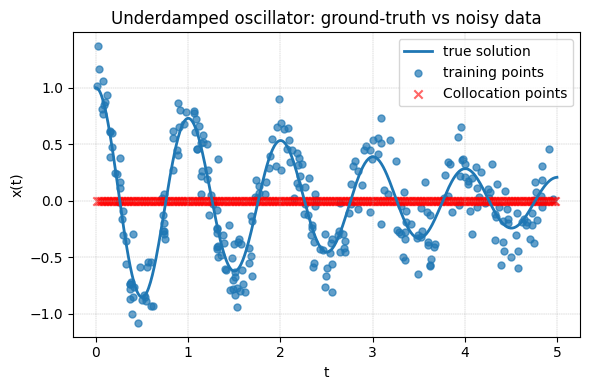

In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR

torch.set_num_threads(4)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 300

data_noise = 0.2
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(x_colloc_num, data_noise)


# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)

# Dense grid for nice plotting
grid_test = torch.linspace(*domain, 800).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [ ]:
# UQ Model
from utils_uqmd.utils_uq_distance import DistanceUQPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[64, 128, 265, 265, 128, 64],
    "output_dim":1,
}

uqmodel = DistanceUQPINN(**model_args)
alpha = 0.05


# Fit the data
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=20000,
    λ_pde= 3.0, λ_ic=10.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
print(f"\n[🟠] Training...")
baseline_loss_dict = uqmodel.fit(**fit_args, **fit_kwargs_grid)

# Model Inferencing
baseline_pred_kwargs = dict(n_samples=200)
print(f"\n[🟠] Base Model Inferencing...")
cp_uncal_predset = uqmodel.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


[🟠] Training...
ep     1 | L=1.09e+01 | lr=1.0e-03
ep   500 | L=9.79e+00 | lr=1.0e-03
ep  1000 | L=9.30e+00 | lr=1.0e-03
ep  1500 | L=8.65e+00 | lr=1.0e-03
ep  2000 | L=9.07e+00 | lr=1.0e-03
ep  2500 | L=1.02e+01 | lr=1.0e-03
ep  3000 | L=9.33e+00 | lr=1.0e-03
ep  3500 | L=8.29e+00 | lr=1.0e-03
ep  4000 | L=9.79e+00 | lr=1.0e-03
ep  4500 | L=7.37e+00 | lr=1.0e-03
ep  5000 | L=8.33e+00 | lr=1.0e-03
ep  5500 | L=7.48e+00 | lr=5.0e-04
ep  6000 | L=7.19e+00 | lr=5.0e-04
ep  6500 | L=7.07e+00 | lr=5.0e-04
ep  7000 | L=7.04e+00 | lr=5.0e-04
ep  7500 | L=7.02e+00 | lr=5.0e-04
ep  8000 | L=6.99e+00 | lr=5.0e-04
ep  8500 | L=6.96e+00 | lr=5.0e-04
ep  9000 | L=6.91e+00 | lr=5.0e-04
ep  9500 | L=6.85e+00 | lr=5.0e-04
ep 10000 | L=6.85e+00 | lr=5.0e-04
ep 10500 | L=6.11e+00 | lr=2.5e-04
ep 11000 | L=5.70e+00 | lr=2.5e-04
ep 11500 | L=5.14e+00 | lr=2.5e-04
ep 12000 | L=4.42e+00 | lr=2.5e-04
ep 12500 | L=2.97e+00 | lr=2.5e-04
ep 13000 | L=2.26e+00 | lr=2.5e-04
ep 13500 | L=2.08e+00 | lr=2.5e-04
ep 

In [31]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP, adaptive_cp_test_uncertainties_grid
adap_cp = AdaptiveCP(uqmodel, alpha=0.1)
cp_cal_predset = adap_cp.predict(
    alpha=0.05, X_test=grid_test, X_train=X_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, k=15
)

[AdaptiveCP] Warning: using α=0.1; requested 0.05.

[🟠] Training Adaptive CP Model


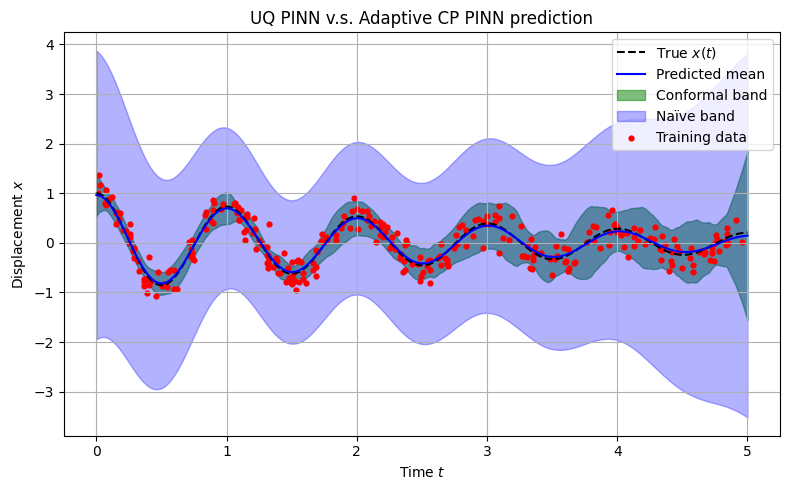

In [12]:
from utils_tools.utils_result_viz import plot_1d_intervals_comparison
plot_1d_intervals_comparison(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution,            # pass the function
    t_train=X_train,
    y_train=Y_train,
    title="UQ PINN v.s. Adaptive CP PINN prediction"
)

In [13]:
# Normal CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",  # Change this based on cp
        "k":10
}
from utils_uqmd.utils_uq_cp import CP
cp_model = CP(uqmodel)
cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=grid_test,
            **cp_pred_kwargs
        )

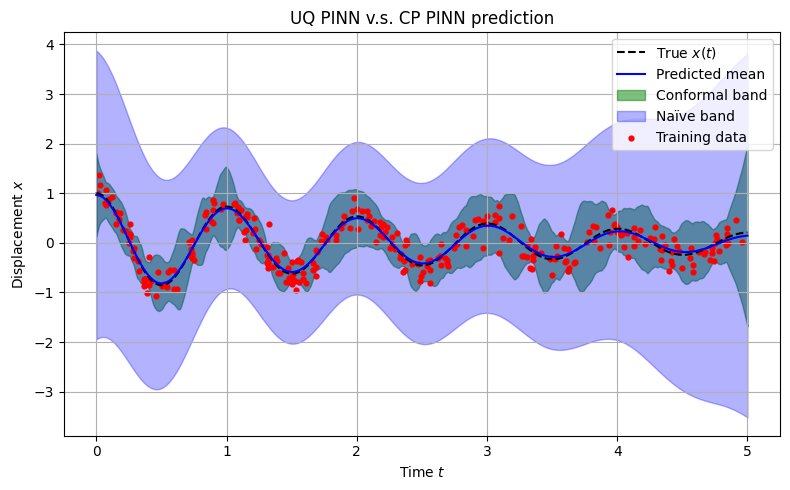

In [14]:
plot_1d_intervals_comparison(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution,            # pass the function
    t_train=X_train,
    y_train=Y_train,
    title="UQ PINN v.s. CP PINN prediction"
)

In [32]:
# CP Coverage comparison
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
alphas = torch.linspace(0.01, 0.99, 20).view(-1, 1)
cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":10
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":10
}
cp_df = cp_test_uncertainties(**cp_testing_args)
adap_df = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:  20%|██        | 4/20 [00:00<00:00, 31.58it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid:  60%|██████    | 12/20 [00:00<00:00, 31.96it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


Adaptive-CP grid: 100%|██████████| 20/20 [00:00<00:00, 30.80it/s]


[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model

[🟠] Training Adaptive CP Model


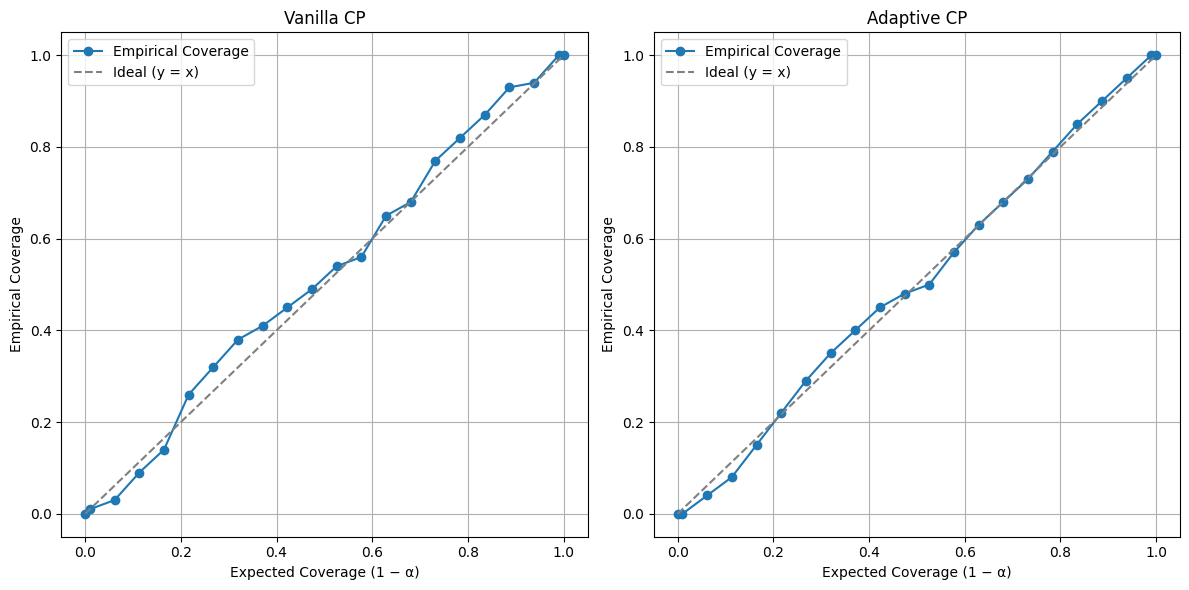

In [33]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(cp_df, adap_df, title1="Vanilla CP", title2="Adaptive CP")

In [25]:
cp_df

,alpha,coverage,sharpness,sdcv,interval score
0,0.010000,1.00,1.930583,0.315783,1.930583
1,0.061579,0.94,1.033932,0.315783,1.080932
2,0.113158,0.93,0.895821,0.315783,0.981888
3,0.164737,0.87,0.695583,0.315783,0.842228
4,0.216316,0.82,0.589805,0.315783,0.761390
5,0.267895,0.77,0.516711,0.315783,0.695853
6,0.319474,0.68,0.408032,0.315783,0.630871
7,0.371053,0.65,0.380511,0.315783,0.593138
8,0.422632,0.56,0.331479,0.315783,0.557794
9,0.474211,0.54,0.311415,0.315783,0.530740


In [26]:
adap_df

,alpha,coverage,sharpness,sdcv,interval score
0,0.010000,1.00,1.930583,0.315783,1.930583
1,0.061579,0.94,1.033932,0.315783,1.080932
2,0.113158,0.93,0.895821,0.315783,0.981888
3,0.164737,0.87,0.695583,0.315783,0.842228
4,0.216316,0.82,0.589805,0.315783,0.761390
5,0.267895,0.77,0.516711,0.315783,0.695853
6,0.319474,0.68,0.408032,0.315783,0.630871
7,0.371053,0.65,0.380511,0.315783,0.593138
8,0.422632,0.56,0.331479,0.315783,0.557794
9,0.474211,0.54,0.311415,0.315783,0.530740
